### Trying to make a SDXL lora

In [1]:
# Import necessary libraries
from diffusers import DiffusionPipeline
import torch
from accelerate import Accelerator

# Initialize the Accelerator
accelerator = Accelerator()


In [6]:
# log into hf
from huggingface_hub import login
login()

: 

In [1]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/home/rlazzaroni/lora/dog'

## SDXL inference test

In [2]:
from diffusers import DiffusionPipeline
import torch

pipeline=DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",torch_dtype=torch.float16, variant="fp16", ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
image=pipeline("a painting of the son of man by Magritte but with avocado instead of an apple, in the style of Leonardo da vinci, abstract, vaporwave, by Goya, Nanni Moretti, Kanye West", num_inference_steps=25, num_images_per_prompt=1, height=1000, width=1000)

  0%|          | 0/25 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 233.56 MiB is free. Including non-PyTorch memory, this process has 10.52 GiB memory in use. Of the allocated memory 8.38 GiB is allocated by PyTorch, and 1.94 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

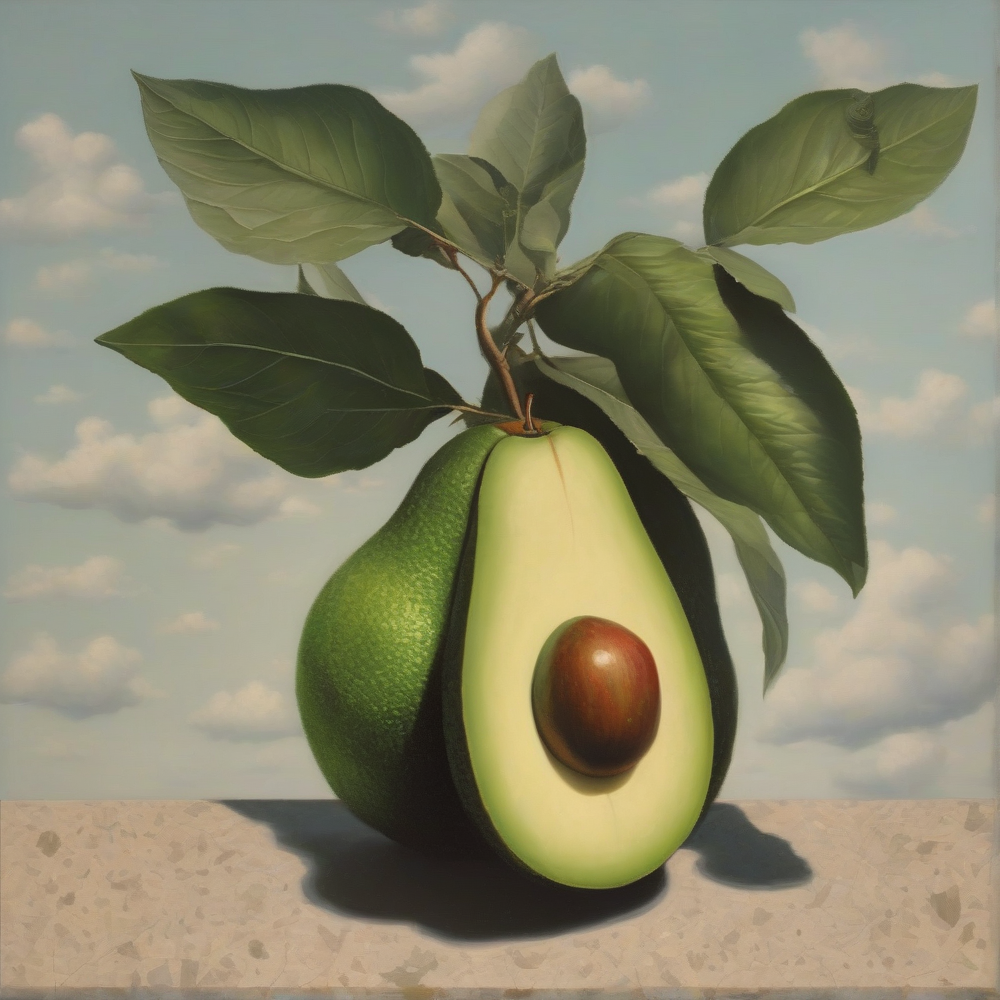

In [6]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

# save img
image[0][0]

## Finetuning dataset

In [1]:
from datasets import load_dataset

dataset=load_dataset("imagefolder", data_dir="./roman_mosaics/")



Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
# login into huggingface
from huggingface_hub import login
login()



In [18]:
import huggingface_hub

dataset.push_to_hub("ruggsea/roman_mosaics")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ruggsea/roman_mosaics/commit/46e2e63ff6b2fd35ec796eed5073dc3378cd3dc2', commit_message='Upload dataset', commit_description='', oid='46e2e63ff6b2fd35ec796eed5073dc3378cd3dc2', pr_url=None, pr_revision=None, pr_num=None)

## Testing lora

In [1]:
from huggingface_hub.repocard import RepoCard
from diffusers import DiffusionPipeline
import torch

g_cuda = torch.Generator(device='cuda').manual_seed(0)

print(g_cuda.seed())
lora_model_id = "ruggsea/roman-mosaics-lora"
card = RepoCard.load(lora_model_id)
base_model_id = card.data.to_dict()["base_model"]

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
pipe=pipe.to("cuda:1")
image_base=pipe("a photo of rmos mosaic of a dog", num_inference_steps=25, height=1000, width=1000,generator=g_cuda).images[0]

pipe.load_lora_weights(lora_model_id)
image = pipe("a photo of rmos mosaic of a dog", num_inference_steps=25, height=1000, width=1000, generator=g_cuda).images[0]
pipe.to("cuda:0")


# display the images side by side
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_base)
ax2.imshow(image)

# labels for the images, base and lora
ax1.set_title("Base model")
ax2.set_title("roman mosaics lora model")
# get rid of the axis
ax1.axis("off")
ax2.axis("off")

# save image
plt.savefig("base_vs_lora.png")

# show
plt.show()


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.1.2)
    Python  3.11.7 (you have 3.11.5)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Converting Lora for web-ui usage

In [3]:
from pathlib import Path
from diffusers import StableDiffusionXLPipeline
import torch
from safetensors.torch import save_file

# text_encoder.text_model.encoder.layers.0.self_attn.k_proj.lora_linear_layer.down.weight
# lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight
# 1. text_encoder -> lora_te, text_encoder_2 -> lora_te2
# 2. map
# 3. .weight -> 2 .alpha -> 1 and replace . -> _
# test:
# 1. lora_te.text_model.encoder.layers.0.self_attn.k_proj.lora_linear_layer.down.weight
# 2. lora_te.text_model.encoder.layers.0.self_attn.k_proj.lora_down.weight
# 2. lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight

# unet.down_blocks.1.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.down.weight
# lora_unet_down_blocks_1_attentions_0_transformer_blocks_0_attn1_to_k.lora_down.weight
# 1. unet -> lora_unet
# 2. map
# 4. .weight -> 2 .alpha -> 1 and replace . -> _
# test:
# 1. lora_unet.down_blocks.1.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.down.weight
# 2. lora_unet.down_blocks_1_attentions_0_transformer_blocks_0_attn1.to_k.lora_down.weight
# 4. lora_unet_down_blocks_1_attentions_0_transformer_blocks_0_attn1_to_k.lora_down.weight


pipe=pipe

state_dict, network_alphas = pipe.lora_state_dict(lora_model_id)

LORA_CLIP_MAP = {
    "mlp.fc1": "mlp_fc1",
    "mlp.fc2": "mlp_fc2",
    "self_attn.k_proj": "self_attn_k_proj",
    "self_attn.q_proj": "self_attn_q_proj",
    "self_attn.v_proj": "self_attn_v_proj",
    "self_attn.out_proj": "self_attn_out_proj",
    "lora_linear_layer.down": "lora_down",
    "lora_linear_layer.up": "lora_up",
}

LORA_UNET_MAP = {
    "processor.to_q_lora.down": "to_q.lora_down",
    "processor.to_q_lora.up": "to_q.lora_up",
    "processor.to_k_lora.down": "to_k.lora_down",
    "processor.to_k_lora.up": "to_k.lora_up",
    "processor.to_v_lora.down": "to_v.lora_down",
    "processor.to_v_lora.up": "to_v.lora_up",
    "processor.to_out_lora.down": "to_out_0.lora_down",
    "processor.to_out_lora.up": "to_out_0.lora_up",
    "processor.to_q.alpha": "to_q.alpha",
    "processor.to_k.alpha": "to_k.alpha",
    "processor.to_v.alpha": "to_v.alpha",
}


webui_lora_state_dict = {}

for k, v in state_dict.items():
    is_text_encoder = False
    prefix = k.split(".")[0]
    if prefix == "text_encoder":
        k = k.replace("text_encoder", "lora_te1")
        is_text_encoder = True
    elif prefix == "text_encoder_2":
        k = k.replace("text_encoder_2", "lora_te2")
        is_text_encoder = True
    elif prefix == "unet":
        k = k.replace("unet", "lora_unet")

    if is_text_encoder:
        for map_k, map_v in LORA_CLIP_MAP.items():
            k = k.replace(map_k, map_v)
    else:
        for map_k, map_v in LORA_UNET_MAP.items():
            k = k.replace(map_k, map_v)

    keep_dots = 0
    if k.endswith(".alpha"):
        keep_dots = 1
    elif k.endswith(".weight"):
        keep_dots = 2
    parts = k.split(".")
    k = "_".join(parts[:-keep_dots]) + "." + ".".join(parts[-keep_dots:])

    webui_lora_state_dict[k] = v

save_file(webui_lora_state_dict, "roman_mosaics.safetensors")